In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

In [4]:
import multiprocessing as mp

In [5]:
from multiprocessing import cpu_count

In [6]:
from functools import partial, reduce

In [7]:
from web_tracking.pre_processing.raw_data_processor import RawDataProcessor

In [8]:
from web_tracking.pre_processing.trajectories.binned_non_stationary_trajectory import BinnedNonStationaryTrajectory
from web_tracking.pre_processing.trajectories.sequential_non_stationary_trajectory import SequentialNonStationaryTrajectory
from web_tracking.pre_processing.trajectories.binned_stationary_trajectory import BinnedStationaryTrajectory

In [9]:
from web_tracking.facades.analysis import Analysis
from web_tracking.measures.entropy import Entropy
from web_tracking.measures.entropy_rate import EntropyRate
from web_tracking.measures.predictability import Predictability

# Load data

<div class="alert alert-warning">
<b>Warning:</b> Update the data directory path before running. 
</div>

We tested this code using the data available at https://zenodo.org/record/4383164

In [10]:
data_directory = "../../../../../../data/web_routineness_release_clean/"

In [11]:
SELECTED_USER_IDS = pd.read_csv(data_directory + '/pre_processed/selected_users.csv')

In [12]:
# processed data
processed = pd \
        .read_csv(
            data_directory + "/pre_processed/browsing_with_gap.csv", 
            dtype={'id': int, 'panelist_id': int, 'prev_id': int}, 
            parse_dates=['used_at', 'left_at'],
            converters={
                'category_names'    : lambda text: None if pd.isnull(text) else tuple(text.split(',')),
                'category_names_top': lambda text: None if pd.isnull(text) or text == '' else tuple(text.split(',')),
                'category_names_sub': lambda text: None if pd.isnull(text) or text == '' else tuple(text.split(',')),
            }
        )


RDP  = RawDataProcessor(processed)
RDP.create_time_series(uid='id', 
                       user='panelist_id', 
                       url='url', 
                       domain='domain', 
                       category='category', 
                       starts='used_at', 
                       active_seconds='active_seconds')

TRAJECTORY_PROCESSED = RDP.df.copy()

# Creating trajectories and estimating predictability 

<div class="alert alert-warning">
<b>Warning:</b> The following cell takes a while to execute.
</div>

In [13]:
analysis = Analysis()

#### Binned non-stationary trajectories

In [14]:
BNST = BinnedNonStationaryTrajectory(TRAJECTORY_PROCESSED)

BNST_domain,        = BNST.create(features=['domain'], bin_size=60).values()

BNST_domain.to_csv(
    data_directory + '/computation_output/binned_non_stationary_trajectory/binned_non_stationary_trajectory.csv', 
    index=False)

In [15]:
BNST_domain_ = SELECTED_USER_IDS.merge(BNST_domain, on='user')
bnst_entropy = analysis.compute_entropy(BNST_domain_, features=['domain'], workers=cpu_count())
bnst_predictability = analysis.compute_predictability(bnst_entropy, features=['domain'])

/Users/juhi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/Users/juhi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/juhi/anaconda3/lib/python3.7/site-packages/web_tracking-0.1-py3.7.egg/web_tracking/measures/predictability.py:74: RuntimeWarning: invalid value encountered in log2
  return -x*np.log2(x) - (1 - x)*(np.log2(1-x)) + (1 - x)*(np.log2(n-1)) - s


In [16]:
bnst_entropy.to_csv(
    data_directory + '/computation_output/binned_non_stationary_trajectory/entropy.csv', 
    index=False)

bnst_predictability.to_csv(
    data_directory + '/computation_output/binned_non_stationary_trajectory/predictability.csv', 
    index=False)

#### Sequential non-stationary trajectories

In [17]:
SNST = SequentialNonStationaryTrajectory(TRAJECTORY_PROCESSED)
SNST_domain, = SNST.create(features=['domain'], threshold=180).values()

SNST_domain.to_csv(
    data_directory + '/computation_output/sequential_non_stationary_trajectory/sequential_non_stationary_trajectory.csv', 
    index=False)

In [19]:
SNST_domain_ = SELECTED_USER_IDS.merge(SNST_domain, on='user')
snst_entropy = analysis.compute_entropy(SNST_domain_, features=['domain'], workers=cpu_count())
snst_predictability = analysis.compute_predictability(snst_entropy, features=['domain'])

/Users/juhi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/juhi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/Users/juhi/anaconda3/lib/python3.7/site-packages/web_tracking-0.1-py3.7.egg/web_tracking/measures/predictability.py:74: RuntimeWarning: invalid value encountered in log2
  return -x*np.log2(x) - (1 - x)*(np.log2(1-x)) + (1 - x)*(np.log2(n-1)) - s


In [20]:
snst_entropy.to_csv(
    data_directory + '/computation_output/sequential_non_stationary_trajectory/entropy.csv', 
    index=False)

snst_predictability.to_csv(
    data_directory + '/computation_output/sequential_non_stationary_trajectory/predictability.csv', 
    index=False)

#### Binned stationary trajectories

In [21]:
BST = BinnedStationaryTrajectory(TRAJECTORY_PROCESSED)
BST_domain = BST.create(features=['domain'], bin_size=60)

BST_domain.to_csv(
    data_directory + '/computation_output/stationary_trajectory/stationary_trajectory.csv', 
    index=False)

In [22]:
BST_domain_ = SELECTED_USER_IDS.merge(BST_domain, on='user')
bst_entropy = analysis.compute_entropy(BST_domain_, features=['domain'], workers=cpu_count())
bst_predictability = analysis.compute_predictability(bst_entropy, features=['domain'])

In [23]:
bst_entropy.to_csv(
    data_directory + '/computation_output/stationary_trajectory/entropy.csv', 
    index=False)

bst_predictability.to_csv(
    data_directory + '/computation_output/stationary_trajectory/predictability.csv', 
    index=False)

# Predictability and trajectory length

In this analysis, we use 100 users with the longest trajectories:

In [24]:
BNST_domain_sample = BNST_domain \
                        .groupby('user', as_index=False) \
                        .agg({
                            'feat_group': 'count',
                            'domain': list
                        }) \
                        .nlargest(100, 'feat_group') \
                        .tail(100)

In [25]:
def quantile(n):
    def quantile_(x):
        return np.quantile(x, n)
    quantile_.__name__ = 'quantile_%s' % n
    return quantile_

def execute_incremental_predictability(df, min_len, max_len, points):
    increment = (max_len-min_len)//points
    for s in range(min_len, max_len+increment, increment):
        df[f'domain_{s}'] = df['domain'].apply(lambda l: l[:s])
        df[f'domain_{s}_unique'] = df[f'domain_{s}'].apply(set).apply(len)
        df[f'domain_{s}_entropy_lz'] = df[f'domain_{s}'].apply(EntropyRate.__lempel_ziv_estimate__)
        df[f'domain_{s}_predictability'] = df.apply(lambda r: Predictability.__pi__(r[f'domain_{s}_unique'], r[f'domain_{s}_entropy_lz']),axis=1)
    return df


MIN = 10
MAX = 1855
POINTS = 1000
INC = (MAX-MIN)//POINTS

<div class="alert alert-warning">
<b>Warning:</b> The following cell takes a while to execute. It creates many jobs to finish faster.
</div>

In [26]:
BNST_domain_sample_split = np.array_split(BNST_domain_sample.copy(), mp.cpu_count())
with mp.Pool(mp.cpu_count()) as pool:
    DF_INC_PREDICTABILITY = pd.concat(pool.map(partial(execute_incremental_predictability, min_len=MIN, max_len=MAX, points=POINTS), BNST_domain_sample_split))

/Users/juhi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Let's plot it:

In [27]:
COLS_PRED = [f'domain_{s}_predictability'for s in range(MIN, MAX+INC, INC)]

DF_INC_PREDICTABILITY_view = DF_INC_PREDICTABILITY[['user', *COLS_PRED]].set_index('user').stack().to_frame() \
                                .reset_index() \
                                .assign(level_1 = lambda df: df['level_1'].apply(lambda text: int(text.split('_')[1]))) \
                                .rename(columns={'level_1': 'length', 0: 'pi_max'}) \
                                .assign(
                                    is_user_same = lambda df: (df['user'] == df['user'].shift()),
                                    pi_max_diff = lambda df: df['is_user_same'] * (df['pi_max'] - df['pi_max'].shift())
                                )

DF_INC_PREDICTABILITY_view_absolute = DF_INC_PREDICTABILITY[['user', *COLS_PRED]].set_index('user').stack().to_frame() \
                                        .reset_index() \
                                        .assign(level_1 = lambda df: df['level_1'].apply(lambda text: int(text.split('_')[1]))) \
                                        .rename(columns={'level_1': 'length', 0: 'pi_max'}) \
                                        .assign(
                                            is_user_same = lambda df: (df['user'] == df['user'].shift()),
                                            pi_max_diff = lambda df: (df['is_user_same'] * (df['pi_max'] - df['pi_max'].shift())).apply(abs)
                                        ).drop(columns=['is_user_same'])

DF_INC_PREDICTABILITY_view_absolute_mean = DF_INC_PREDICTABILITY_view_absolute \
                                                .groupby('length', as_index=False) \
                                                .agg({'pi_max': 'mean', 'pi_max_diff': 'mean'})

In [28]:
DF_INC_PREDICTABILITY_view_absolute_lines = DF_INC_PREDICTABILITY_view_absolute \
                                                .groupby('length') \
                                                .agg({
                                                    'pi_max_diff': ['min', 'max', quantile(.05), quantile(.95)]
                                                })

DF_INC_PREDICTABILITY_view_absolute_lines.columns = ['min', 'max', 'quantile_.05', 'quantile_.95']

DF_INC_PREDICTABILITY_view_absolute_lines = DF_INC_PREDICTABILITY_view_absolute_lines \
                                                .reset_index() \
                                                .rename(columns={'index': 'length'}) \
                                                .query('length > 10')

/Users/juhi/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [29]:
DF_INC_PREDICTABILITY_view_absolute_mean = DF_INC_PREDICTABILITY_view_absolute_mean.query('length > 10')

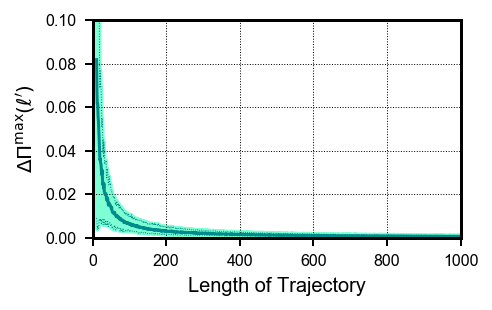

In [30]:
ARGS = dict(grid=True, xlim=(0, 1000), ylim=(0, .1), color='darkcyan', legend=None,)

ax = DF_INC_PREDICTABILITY_view_absolute_mean \
        .plot(x='length', y='pi_max_diff', **ARGS)

DF_INC_PREDICTABILITY_view_absolute_lines \
    .plot(x='length', y=['quantile_.05', 'quantile_.95'], ax=ax, linewidth=0.5, linestyle=':', **ARGS)

ax \
    .fill_between(DF_INC_PREDICTABILITY_view_absolute_lines['length'],
                  DF_INC_PREDICTABILITY_view_absolute_lines['quantile_.05'],
                  DF_INC_PREDICTABILITY_view_absolute_lines['quantile_.95'],
                  color='aquamarine')
ax.set_xlabel('Length of Trajectory')
ax.set_ylabel("$\Delta \Pi^{max}(\ell')$", );

# Stationarity 

In [31]:
LINE_STYLES =['-',  ':', '-.', (0, (3, 1, 1, 1, 1, 1)), '--']

['0.5811', '0.6767', '0.8308']

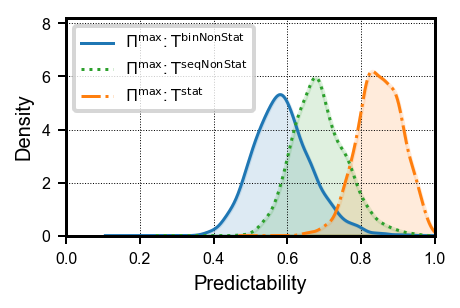

In [32]:
# AX_COLORS = ['deepskyblue', 'forestgreen', 'coral']
AX_COLORS = ['#1f77b4', '#2ca02c', '#ff7f0e']
ARGS = dict(xlim=(0, 1), ylim=(0, 8.2), grid=True)


ax = bnst_predictability['domain_pi_max'] \
        .plot.kde(**ARGS, color=AX_COLORS[0])

snst_predictability['domain_pi_max'] \
    .plot.kde(**ARGS, color=AX_COLORS[1], ax=ax)

bst_predictability['domain_pi_max'] \
    .plot.kde(**ARGS, color=AX_COLORS[2], ax=ax)

ax.set_xlabel('Predictability')

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    x = line.get_xydata()[:, 0]
    y = line.get_xydata()[:, 1]
    ax.fill_between(x, y, color=color, alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])
    line.set_linestyle(style)

ax.legend(ax.get_lines(), ['$\Pi^{max}$: $T^{binNonStat}$', '$\Pi^{max}$: $T^{seqNonStat}$', '$\Pi^{max}$: $T^{stat}$',], loc='best')
[ f'{m:.4f}' for m in maxes ]

# Temporal resolution

In [33]:
def generate_binned_trajectory(df, bin_size):
    BST = BinnedStationaryTrajectory(df)
    return BST.create(bin_size=bin_size)

In [34]:
TRAJECTORY_PROCESSED_sample = TRAJECTORY_PROCESSED.query("user == 2042")

TRAJECTORY_PROCESSED_temporal = pd.concat([
    generate_binned_trajectory(TRAJECTORY_PROCESSED_sample, i).groupby('user', as_index=False).agg({'domain': list}).assign(bin=i)
    for i in [15, 30, 45, *range(60, 16*60, 60)]
]).reset_index(drop=True)

df_impact_temporal = TRAJECTORY_PROCESSED_temporal \
                        .assign(
                            visits          = lambda df: df['domain'].apply(len),
                            unique          = lambda df: df['domain'].apply(lambda ds: len(set(ds))),
                            entropy_random  = lambda df: df['domain'].apply(Entropy.__random_entropy__),
                            entropy_shannon = lambda df: df['domain'].apply(Entropy.__shannon_entropy__),
                            entropy_lz      = lambda df: df['domain'].apply(EntropyRate.__lempel_ziv_estimate__),
                            pi_max          = lambda df: df.apply(lambda r: Predictability.__pi__(r['unique'], r['entropy_lz']), axis=1),
                            bin_size        = lambda df: [ f"{b/60:.2f}" if b < 60 else f"{b//60}" for b in df.bin ]
                        ) \
                        .drop(columns=['domain'])



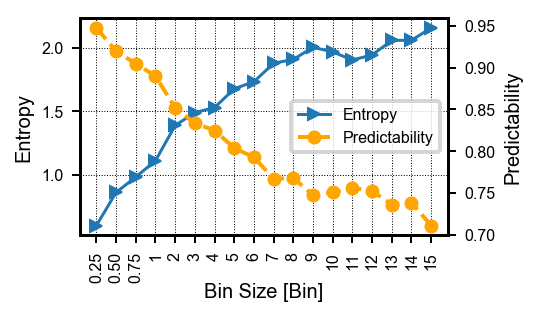

In [35]:
ax = df_impact_temporal \
        .plot(x='bin_size', 
              y='entropy_lz', 
              grid=True, 
              marker='>', label='Entropy')

ax.set_ylabel('Entropy',)
ax.set_xlabel('Bin Size [Bin]', labelpad=0)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))

ax_twinx = ax.twinx()
l = ax_twinx \
        .plot(df_impact_temporal.bin_size, df_impact_temporal.pi_max, linewidth=2.0, color='orange', marker='o', linestyle='--', label='$\Pi^{max}$')
ax_twinx.set_ylabel('Predictability')
ls = [*ax.get_lines(), *l]
ax.legend(ls, ['Entropy', 'Predictability'], loc=7);

# Spatial resolution

In [36]:
TRAJECTORY_RAW = pd \
                    .read_csv(data_directory + '/raw/browsing.csv', usecols=['id', 'panelist_id', 'url'], dtype={'id': int}) \
                    .rename(columns={'panelist_id': 'user', 'id': 'uid'}) \
                    .merge(SELECTED_USER_IDS, on='user') \
                    .merge(TRAJECTORY_PROCESSED, on=['uid', 'user'])

In [37]:
TRAJECTORY_RAW = TRAJECTORY_RAW[TRAJECTORY_RAW.user.isin(SELECTED_USER_IDS.user.values)].copy()

In [38]:
RDP = RawDataProcessor(TRAJECTORY_RAW)
RDP.create_time_series(uid='uid', 
                       user='user', 
                       url='url', 
                       domain='domain', 
                       category='category_names', 
                       starts='starts', 
                       active_seconds='active_seconds')
TRAJECTORY_RAW = RDP.df.copy()

In [39]:
SEQ_NON_STAT = SequentialNonStationaryTrajectory(TRAJECTORY_RAW)

In [40]:
SEQ_NON_STAT_TRAJ = SEQ_NON_STAT.create(threshold=180, features=['url', 'domain', 'category'])

In [41]:
SEQ_NON_STAT_url_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['url'], features=['url'], workers=cpu_count())
SEQ_NON_STAT_url_predictability = analysis.compute_predictability(SEQ_NON_STAT_url_entropy, features=['url'])

In [42]:
SEQ_NON_STAT_domain_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['domain'], features=['domain'], workers=cpu_count())
SEQ_NON_STAT_domain_predictability = analysis.compute_predictability(SEQ_NON_STAT_domain_entropy, features=['domain'])

In [43]:
SEQ_NON_STAT_category_entropy = analysis.compute_entropy(SEQ_NON_STAT_TRAJ['category'], features=['category'], workers=cpu_count())
SEQ_NON_STAT_category_predictability = analysis.compute_predictability(SEQ_NON_STAT_category_entropy, features=['category'])

['0.4227', '0.6767', '0.6940']

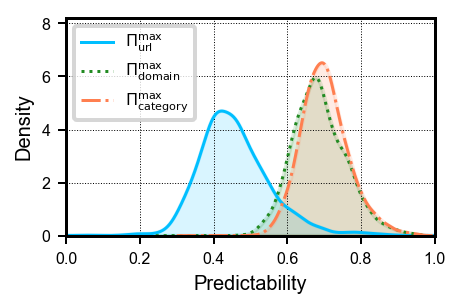

In [44]:
AX_COLORS = ['deepskyblue', 'forestgreen', 'coral']
LINE_STYLES =['-',  ':', '-.', (0, (3, 1, 1, 1, 1, 1)), '--']
# AX_COLORS = ['#1f77b4', '#2ca02c', '#ff7f0e']
ARGS = dict(grid=True, xlim=(0, 1), ylim=(0, 8.2), color=AX_COLORS)

ax = SEQ_NON_STAT_url_predictability[['user', 'url_pi_max']] \
        .merge(SEQ_NON_STAT_domain_predictability[['user', 'domain_pi_max']], on='user') \
        .merge(SEQ_NON_STAT_category_predictability[['user', 'category_pi_max']], on='user')[
            ['url_pi_max', 'domain_pi_max', 'category_pi_max',]
        ] \
        .plot.kde(**ARGS)

ax.set_ylabel('Density')
ax.set_xlabel('Predictability')

maxes = []
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    maxes.append(x[np.where(y == max(y))][0])
    ax.fill_between(x, y, color=color, alpha=0.15)
    
ax.legend(ax.get_lines(),
          ['$\Pi^{max}_{url}$', '$\Pi^{max}_{domain}$', '$\Pi^{max}_{category}$',], loc='best')

[ f'{m:.4f}' for m in maxes ]